## A very basic introduction to torch geometric

**Quick note: The molecule labels aren't right for visualisation, but it can be a fun challenge for you all to fix that**

First check that the main libraries import right:

In [1]:
import torch
import torch_geometric
import numpy as np

Then import some functions from utils 

*(you are welcome to steal these)*

In [2]:
from utils import vis_grid, vis_from_pyg

### Load an existing dataset
In a default way for now

In [3]:
from torch_geometric.datasets import MoleculeNet

dataset = MoleculeNet("datasets/", "BACE")

## What's going on with that data?

As a dataset, you can index it as-normal. Graphs (`data`) can have:

- Edges, `data.edge_index`, a big list of which nodes are connected, shape `2 x N edges`
- Labels or some target, `data.y`. This varies by dataset.
- Node features, `data.x`, an array of shape `N nodes x N node features`
- Edge features, `data.edge_attr`, an array of shape `N edges x N edge features`

**This is the sparse format of data**

See [here](https://pytorch-geometric.readthedocs.io/en/2.5.3/generated/torch_geometric.data.Data.html#torch_geometric.data.Data) for more

In [4]:
print(dataset[0])

Data(x=[32, 9], edge_index=[2, 70], edge_attr=[70, 3], smiles='O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2ccccc2C)C)CC1(C)C', y=[1, 1])


## What do these look like?

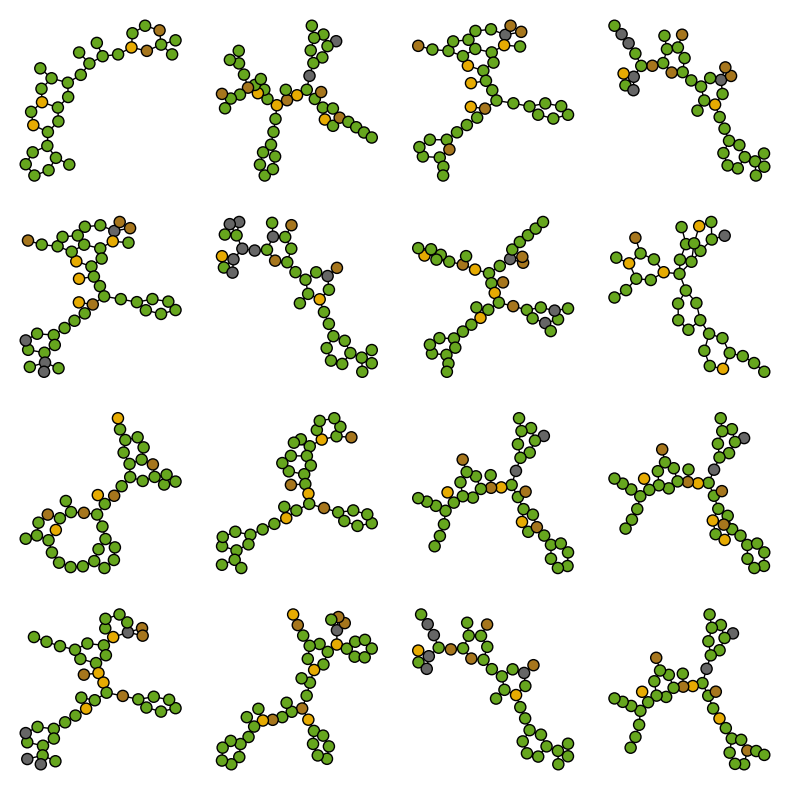

In [5]:
vis_grid(dataset[:16], filename = "example.png", save = False)

### Weird!
We can change the filename to make it actually see molecules

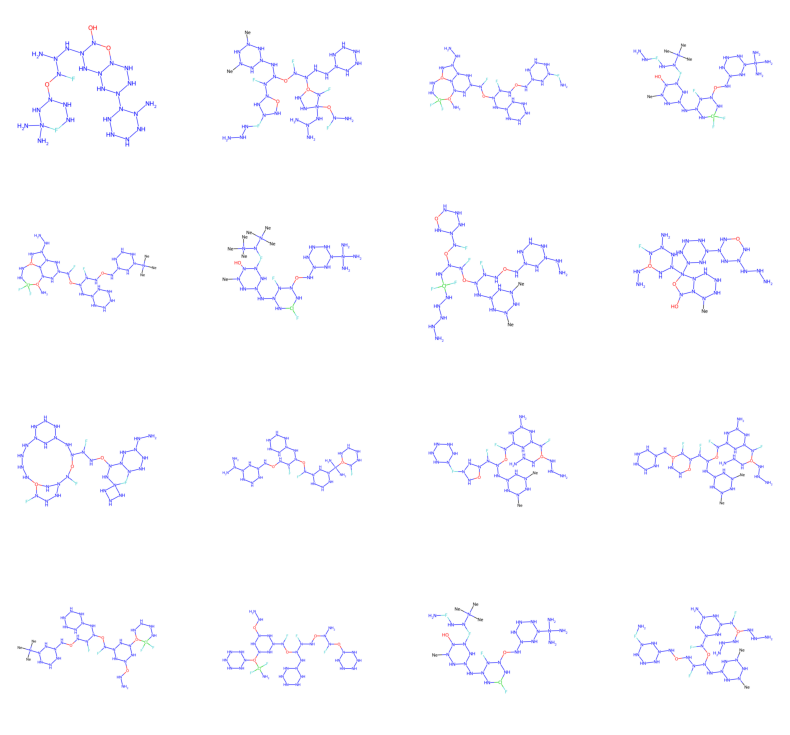

In [6]:
vis_grid(dataset[:16], filename = "ogbg-example.png", save = False)

### Transforms and Pre-Transforms

These do something to the data as you load it, itemwise, either before or after

Here we'll convert the dataset from sparse to dense

'Dense' means an adjacency matrix to describe the graph instead of an edgelist.
This collapses edge attributes into the adjacency matrix too.

Why is dense useful? It lets models also consider where there *aren't* edges.

Why is it not useful? Because its **much** more expensive for most graphs.

In [7]:
import torch_geometric.transforms as T

dataset = MoleculeNet("datasets/", "BACE")
print(dataset)
print(f"Edge index shape: {dataset[0].edge_index.shape}")
print(f"Edge attr shape: {dataset[0].edge_attr.shape}")
print(f"Total entries: {dataset[0].edge_index.shape[0] * dataset[0].edge_index.shape[1] + dataset[0].edge_attr.shape[0] * dataset[0].edge_attr.shape[1]}")

dataset = MoleculeNet("datasets/", "BACE", transform=T.ToDense())
print(dataset)
print(f"Adj matrix shape: {dataset[0].adj.shape}")
print(f"Total entries: {dataset[0].adj.shape[0] * dataset[0].adj.shape[1] * dataset[0].adj.shape[2]}")



BACE(1513)
Edge index shape: torch.Size([2, 70])
Edge attr shape: torch.Size([70, 3])
Total entries: 350
BACE(1513)
Adj matrix shape: torch.Size([32, 32, 3])
Total entries: 3072


## Custom transform

Here's a custom transform that removes node and edge features

Data(edge_index=[2, 70], smiles='O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2ccccc2C)C)CC1(C)C', y=[1, 1])


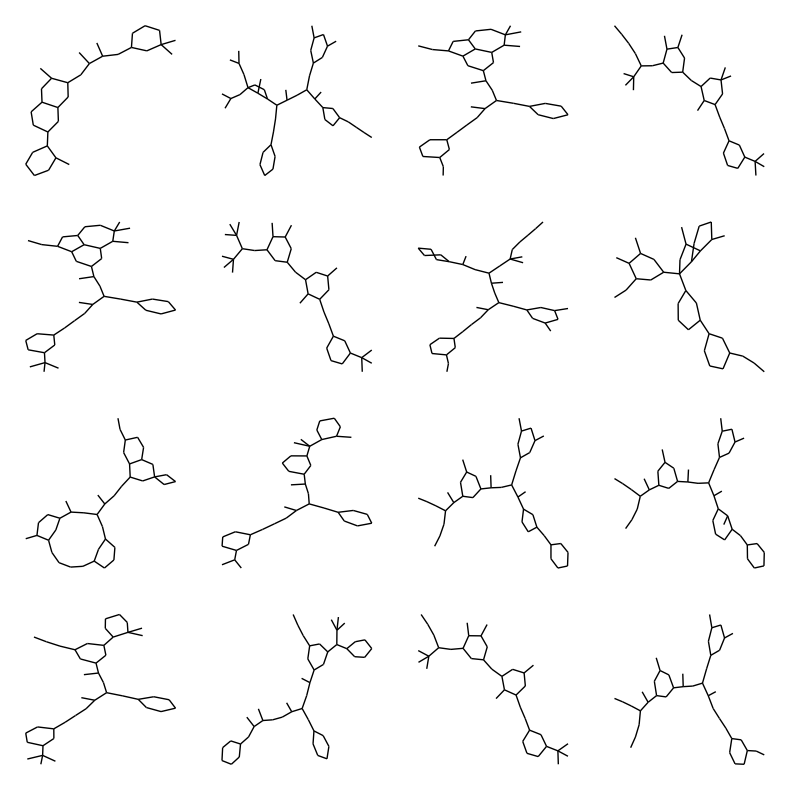

In [8]:
class RemoveFeatures(T.BaseTransform):
    r"""Distance to nodes
    """

    def __init__(self):
        pass

    def __call__(self, data):
        data.x = None
        data.edge_attr = None

        return data
    
dataset = MoleculeNet("datasets/", "BACE", transform=RemoveFeatures())
print(dataset[0])
vis_grid(dataset[:16], filename = "example.png", save = False)

## Exercise
*sorry*

1. Write a transform that adds the degree of each node as a new feature
2. Write the same transform, but it keeps the original features, and adds degree as a new one

Data(x=[32, 9], edge_index=[2, 70], edge_attr=[70, 3], smiles='O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2ccccc2C)C)CC1(C)C', y=[1, 1], edge_degree=[32])


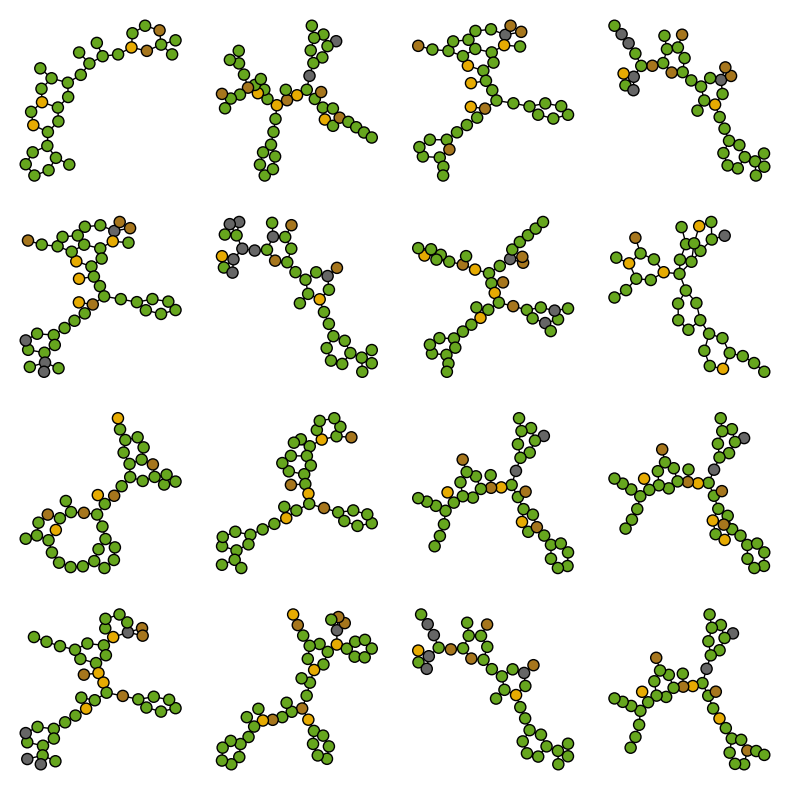

Data(edge_index=[2, 70], smiles='O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2ccccc2C)C)CC1(C)C', y=[1, 1], edge_degree=[32])


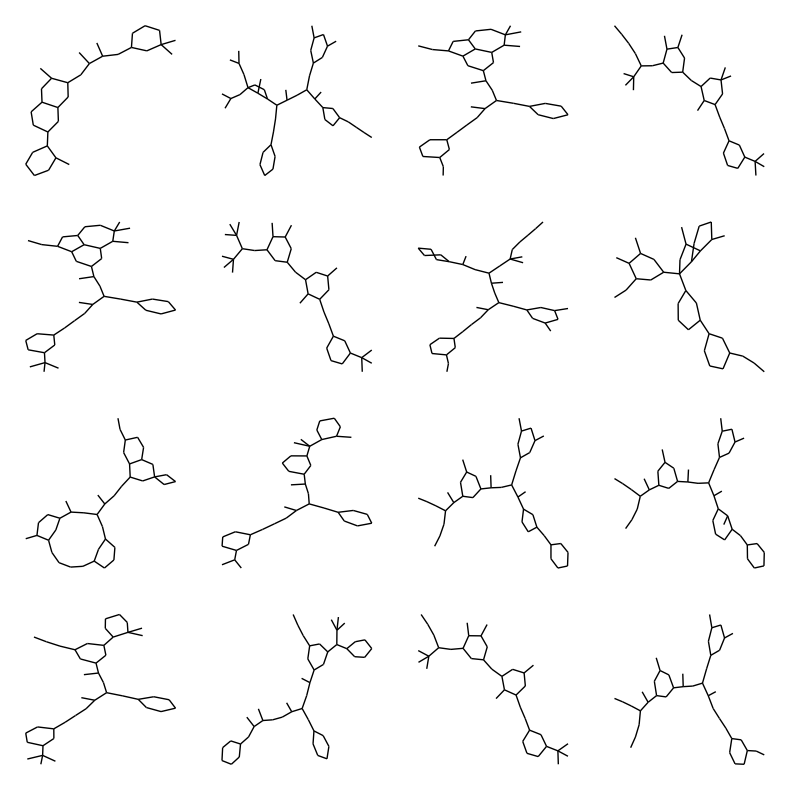

In [9]:
# Your code here

class DegreeGiver(T.BaseTransform):
    def __init__(self):
        pass

    def __call__(self, data):
        data.edge_degree = data.edge_index[0].unique(return_counts=True)[1]

        return data

class DegreeNoFeatures(T.BaseTransform):
    def __init__(self):
        pass

    def __call__(self, data):
        data.edge_degree = data.edge_index[0].unique(return_counts=True)[1]
        data.x = None
        data.edge_attr = None

        return data


dataset = MoleculeNet("datasets/", "BACE", transform=DegreeGiver())
print(dataset[0])
vis_grid(dataset[:16], filename = "example.png", save = False)

dataset = MoleculeNet("datasets/", "BACE", transform=DegreeNoFeatures())
print(dataset[0])
vis_grid(dataset[:16], filename = "example.png", save = False)

There are a lot of complicated things on graph data - but they mostly do things to features or structure separately.

## PyG batches

Batches for pytorch-geometric - and most graph libraries - treat each batch as one big graph.

This batch object has attribute `.batch`, like `batch.x` or `batch.edge_index`, that indexes which nodes belong to which batch.

DataBatch(x=[325, 9], edge_index=[2, 698], edge_attr=[698, 3], smiles=[8], y=[8, 1], batch=[325], ptr=[9])


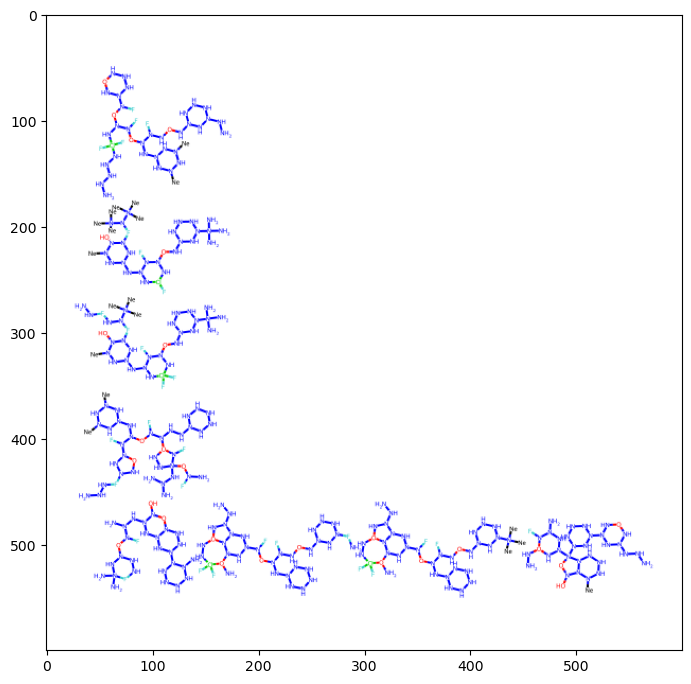

In [10]:
from torch_geometric.loader import DataLoader

dataset = MoleculeNet("datasets/", "BACE")
loader = DataLoader(dataset, batch_size = 8)
print(loader)
for batch in loader:
    print(batch)
    vis_from_pyg(batch, filename="ogbg.png", save=False)
    break